# Gaussian Mixture Integration

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = Path(os.getcwd()).parents[0]
sys.path.append(str(path_root))
%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import deepcopy
import itertools
from sklearn.model_selection import train_test_split
import mlflow

In [3]:
import jax
import jax.numpy as jnp
from jax import vmap, jit
from tensorflow_probability.substrates.jax import distributions as tfd
import optax
import equinox as eqx
from jax.lib import xla_bridge

In [4]:
from solstice.kernels import RBF, RFF, Matern32
from solstice.gp import GP, LowRankGP, fitgp
from solstice.transforms import ARD, FiniteARD
from ffbq.helpers import grid, regrid
from ffbq.bq import BQ
from ffbq.eval import generate_data, metric_gp_kmu_var, metric_gp_time, metric_gp_bq

I0000 00:00:1701667323.899393       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [5]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: cpu


# Data Generator

In [6]:
class GMMData:
    def __init__(self, d, bound=5):
        # make mixture components
        mu1 = jnp.ones(d) * -0.5
        mu2 = jnp.ones(d) * 0.5
        sigma1 = jnp.ones(d)
        sigma2 = jnp.ones(d) * 1.5
        w = jnp.array([1/3, 2/3])

        m1 = tfd.MultivariateNormalDiag(mu1, sigma1)
        m2 = tfd.MultivariateNormalDiag(mu2, sigma2)
        self.m = [m1, m2]

        # make mixture
        mus = jnp.stack([mu1, mu2])
        sigmas = jnp.stack([sigma1, sigma2])
        self.mixture = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=w),
            components_distribution=tfd.MultivariateNormalDiag(
                loc=mus, scale_diag=sigmas
            ),
        )
        
        # finalise
        self.bounds = jnp.tile(jnp.array([[-bound], [bound]]), d)
        self.f = self.init_f(m1, m2, w)
        self.d = d

    def sample(self, N, noise=None, from_dist=False, key=jax.random.PRNGKey(2023)):
        if from_dist:
            binom = tfd.Binomial(1, probs=(2/3))
            X = binom.sample(N, key).reshape(-1, 1)
            X = jnp.where(X == 0, self.m[0].sample(N, key), self.m[1].sample(N, key))
        else:
            X = jax.random.uniform(
                key, (N, self.d), minval=self.bounds[0, :], maxval=self.bounds[1, :]
            )

        y = jax.vmap(self.f)(X)
        if noise is not None:
            y_noisy = y + jax.random.normal(key, (N,)) * noise
        else:
            y_noisy = y
        
        return X, y, y_noisy


    def init_f(self, m1, m2, w):
        
        def f(x):
            px = jnp.stack([m1.prob(x), m2.prob(x)])
            return jnp.sum(px * w)
        
        return f
    
    def __call__(self, X):
        return jax.vmap(self.f)(X)


# Define Kernel Mean + Variance Experiment

In [7]:
key = jax.random.PRNGKey(2023)
EXPERIMENT = "gmm_kmu"

In [8]:
from ffbq.conv import gaussian_conv, mc_conv, qmc_conv, fft_conv

def gaussian_bq(gp, m, X, y, key, diag=None):
    bq = BQ(gp, m)
    z, _ = bq.kmu_kvar(X)
    mu, sigma = bq(X, y, key=key, diag=diag)
    return mu, sigma, z

def mc_bq(gp, m, X, y, R, key, diag=None):
    bq = BQ(gp, m, operator="mc")
    z, _ = bq.kmu_kvar(X, R=min(R, 100000), key=key)
    mu, sigma = bq(X, y, R=R, key=key,
                   diag=diag)
    return mu, sigma, z

def qmc_bq(gp, m, X, y, R, key, diag=None):
    bq = BQ(gp, m, operator="qmc")
    z, _ = bq.kmu_kvar(X, R=min(R, 100000), key=key)
    mu, sigma = bq(X, y, R=R, key=key,
                   diag=diag)
    return mu, sigma, z

def fft_bq(gp, m, X, y, sr, bounds, diag=None):
    bq = BQ(gp, m, operator="fft")
    z, _ = bq.kmu_kvar(X, bounds=bounds, sr=sr, bounded=False)
    mu, sigma = bq(X, y, bounds=bounds, sr=sr, diag=diag, bounded=False)
    return mu, sigma, z

def lr_qmc_bq(gp, m, X, y, R, diag=None):
    bq = BQ(gp, m, operator="lr")
    mu, sigma = bq(X, y, R=R, diag=diag)
    return mu, sigma

def lr_fft_bq(gp, m, X, y, sampling_rate, bounds, diag=None):
    bq = BQ(gp, m, operator="lrfft")
    mu, sigma = bq(X, y, bounds=bounds, sr=sampling_rate, diag=diag)
    return mu, sigma

In [10]:
# d = 2
# gmm = GMMData(d)
# m = tfd.MultivariateNormalDiag(jnp.zeros(d), jnp.ones(d) * 5)
# bq_sols = []
# # R = 300
# lr_sols = []
# fft_sols = []
# ns = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 7500, 8000]
# # ns = [5000]
# srs = [1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5.5, 6, 6.5, 7, 7.5, 8]
# sr = 12
# Rs = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# grid_shapes = jnp.array([grid(gmm.bounds, sr, flatten=False).shape[0] for sr in srs])
# sigmas = [1, 2, 3, 4, 5, 6, 7, 8, 9]
# trunc = diag_mvgaussian_trunc_term(m.mean(), m.stddev(), gmm.bounds)
# Nconvs = jnp.array([grid(gmm.bounds, sr).shape[0] for sr in srs])
# for R in Rs:
#     Nconv = grid(gmm.bounds * 3, sr / 3).shape[0]
#     X, y, y_noisy = gmm.sample(8000, from_dist=False, key=key)
#     gp = GP(ARD(jnp.ones(d), RBF()), X, diag=1e-4)
#     gplr = LowRankGP(ARD(jnp.ones(d), RFF(key, d, R, base_kernel=RBF())), X, diag=1e-4)
#     bq_gauss = BQ(gp, m)
#     bq_fft = BQ(gp, m, operator="fft")
#     bq_lr = BQ(gplr, m, operator="lr")

#     # _, bq_Z = bq_gauss.kmu_kvar(X)
#     bq_res = bq_gauss(X, y, diag=1e-1)
#     lr_res = bq_lr(X, y, R=min(Nconv, 500000), key=key, diag=1e-1)
#     # _, fft_Z = bq_fft.kmu_kvar(X, bounds=gmm.bounds * 3, sr=sr / 2, bounded=False)
#     fft_res = bq_fft(X, y, bounds=gmm.bounds * 3, sr=sr / 3, diag=1e-1, bounded=False)

#     bq_sols.append(bq_res)
#     lr_sols.append(lr_res)
#     fft_sols.append(fft_res)
# bq_sols = jnp.array(bq_sols)
# lr_sols = jnp.array(lr_sols)
# fft_sols = jnp.array(fft_sols)

## Define Run

In [9]:
diag = 1e-4
lr = 0.01
epochs = 200

In [10]:
def single_run_gmm(d, R, N, sampling_rate, key, EXPERIMENT=None, log=True):
    print(f'd: {d}, R: {R}, N: {N}, sr: {sampling_rate}')

    diag_rbf = 1e-1
    diag_lr = 1e-1

    if EXPERIMENT is None:
        EXPERIMENT = "gmm_dev"

    gmm = GMMData(d)
    ls_init = jnp.ones(d)

    # make data
    train, val, test = generate_data(gmm, N * 3, N, N, noise=None, key=key)
    X_train, y_train = train
    X_val, y_val = val
    X_test, y_test = test
    Nconv = grid(gmm.bounds * 3, sampling_rate=sampling_rate / 3).shape[0]
    Nconv_cap = 100000
    Nrff_cap = 500000

    # --------------------------------------- TRAIN GPS -------------------------------------- #

    ###### BASIC BQ GP
    def build_train_bq_gp(X, y, opt, epochs, ls_init, diag):
        return GP(ARD(ls_init, RBF()), X, diag=diag)

    gp_bq_opt = optax.adam(lr)
    print("training basic gp...")
    gp_bq = build_train_bq_gp(X_train, y_train, gp_bq_opt, epochs, ls_init, diag)

    ###### RBF GP
    # def build_train_rbf_gp(support, X, y, opt, epochs, ls_init, diag):
    #     gp_pre = GP(FiniteARD(ls_init, RBF(), support), X, diag=diag)

    #     # train
    #     gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: t.kernel.scale, verbose=False, solver="full")
    #     return gp_pre, gp, loss

    # gp_rbf_opt = optax.adam(lr)
    # print("training rbf gp...")
    # _, gp_rbf, _ = build_train_rbf_gp(gmm.bounds, X_train, y_train, gp_rbf_opt, epochs, ls_init, diag)

    ###### LOW RANK RBF GP
    def build_train_lrgp_rbf(d, R, X, y, opt, epochs, ls_init, diag, key):
        return LowRankGP(ARD(ls_init, RFF(key, d, R)), X, diag=diag)

    gp_lr_rbf_opt = optax.adam(lr)
    print("training low rank rbf gp...")
    gp_lr_rbf = build_train_lrgp_rbf(d, R, X_train, y_train, gp_lr_rbf_opt, epochs, ls_init, diag_lr, key=key)

    # make test GPs for BQ
    gp_bq = eqx.tree_at(lambda t: t.X, gp_bq, replace_fn=lambda _: X_val)
    # gp_rbf = eqx.tree_at(lambda t: t.X, gp_rbf, replace_fn=lambda _: X_val)
    gp_lr_rbf = eqx.tree_at(lambda t: t.X, gp_lr_rbf, replace_fn=lambda _: X_val)

    # ---------------------------------------- RUN BQ ---------------------------------------- #
    m = tfd.MultivariateNormalDiag(jnp.zeros(d), jnp.ones(d) * 5)
    print("running BQ models...")

    ########## GAUSSIAN BQ
    rbf_mu, rbf_var, rbf_z = gaussian_bq(gp_bq, m, X_val, y_val, key, diag=diag_rbf)
    sol_mu = (rbf_mu, 0)
    sol_var = (rbf_var, 0)
    sol_z = (rbf_z, 0)
    sols = (sol_mu, sol_var, sol_z)

    ########## MC
    if Nconv > Nconv_cap:
        Nconv_mc = Nconv_cap
        print(f"Capping N mc from {Nconv} to {Nconv_cap}")
    else:
        Nconv_mc = Nconv

    rbf_mc_res, rbf_mc_var, rbf_mc_z = mc_bq(gp_bq, m, X_val, y_val, Nconv_mc, key, diag=diag_rbf)

    ########## QMC
    rbf_qmc_res, rbf_qmc_var, rbf_qmc_z = qmc_bq(gp_bq, m, X_val, y_val, Nconv_mc, key, diag=diag_rbf)

    ########## FFBQ
    rbf_fft_res, rbf_fft_var, rbf_fft_z = fft_bq(
        gp_bq, m, X_val, y_val, sampling_rate / 3, bounds=gmm.bounds * 3, diag=diag_rbf
    )

    ########## SSBQ (QMC)
    if Nconv > Nrff_cap:
        Nrff = Nrff_cap
        print(f"Capping N RFF from {Nconv} to {Nrff_cap}")
    else:
        Nrff = Nconv
    lr_rbf_res, lr_rbf_var = lr_qmc_bq(gp_lr_rbf, m, X_val, y_val, Nrff, diag=diag_lr)

    # ########## SSBQ (FFT)
    # if d < 5:
    #     lrfft_rbf_res, lrfft_rbf_var = lr_fft_bq(gp_lr_rbf, m, X_val, y_val, sampling_rate, gmm.bounds, diag=diag_lr_fft)

    # ----------------------------------- ERROR AND OUTPUT ----------------------------------- #
    mc_rel_errs = jnp.abs(rbf_mc_res - sols[0][0]) / sols[0][0]
    qmc_rel_errs = jnp.abs(rbf_qmc_res - sols[0][0]) / sols[0][0]
    ffbq_rel_errs = jnp.abs(rbf_fft_res - sols[0][0]) / sols[0][0]
    ssbq_rel_errs = jnp.abs(lr_rbf_res - sols[0][0]) / sols[0][0]
    # if d < 5:
    #     ssbq_fft_rel_errs = jnp.abs(jnp.array([lrfft_rbf_res]) - sol[0]) / sol[0]
    # else:
    #     ssbq_fft_rel_errs = None

    print(f"""
        MC: {mc_rel_errs} \n
        QMC: {qmc_rel_errs} \n 
        FFBQ: {ffbq_rel_errs} \n 
        SSBQ (QMC): {ssbq_rel_errs} \n
    """)

    artifacts = {
        "gmm": gmm,
        "m": m,
        "val": (X_val, y_val),
        "test": (X_test, y_test),
        "gps": {
            "rbf": gp_bq,
            "lr_rbf": gp_lr_rbf,
        }
    }
    
    if not log:
        return artifacts

    # -------------------------------------- SAVE MODELS ------------------------------------- #


    ########## MC
    metric_gp_kmu_var(
        gp=gp_bq, bq_res=rbf_mc_res, bq_var=rbf_mc_var, bq_z=rbf_mc_z,
        y_val=y_val, X_test=X_test, y_test=y_test, sols=sols, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="mc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, diag=diag_rbf
    )

    ########## QMC
    metric_gp_kmu_var(
        gp=gp_bq, bq_res=rbf_qmc_res, bq_var=rbf_qmc_var, bq_z=rbf_qmc_z,
        y_val=y_val, X_test=X_test, y_test=y_test, sols=sols, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="qmc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, diag=diag_rbf
    )

    ########## FFBQ
    metric_gp_kmu_var(
        gp=gp_bq, bq_res=rbf_fft_res, bq_var=rbf_fft_var, bq_z=rbf_fft_z,
        y_val=y_val, X_test=X_test, y_test=y_test, sols=sols, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="ffbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv, diag=3e-1
    )

    ########## SSBQ
    metric_gp_kmu_var(
        gp=gp_lr_rbf, bq_res=lr_rbf_res, bq_var=lr_rbf_var, bq_z=None,
        y_val=y_val, X_test=X_test, y_test=y_test, sols=sols, 
        experiment=EXPERIMENT, gptype="lr", ktype="rbf", bqtype="ssbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nrff, R=R
    )

    del artifacts


In [13]:
def multi_seed_run(d, R, N, sampling_rate, global_key, n_runs=10, EXPERIMENT=None, log=True):
    run_keys = jax.random.split(global_key, n_runs)

    artifacts = []
    for rk in run_keys:
        print(f"starting experiment with seed {rk.tolist()[1]}")
        if log:
            single_run_gmm(d, R, N, sampling_rate, rk, EXPERIMENT=EXPERIMENT, log=log)
        else:
            run_artifacts = single_run_gmm(d, R, N, sampling_rate, rk, EXPERIMENT=EXPERIMENT, log=log)
            artifacts.append(run_artifacts)
    return artifacts

## Single Run

In [14]:
# res = single_run_gmm(2, 100, 1000, 10, key, log=False)
# runs = multi_seed_run(d=3, R=100, N=1000, sampling_rate=12, global_key=key, n_runs=5, log=False)

# gp_rbf = res["gps"]["rbf"]
# lr_rff = res["gps"]["lr_rff"]
# lr_rbf = res["gps"]["lr_rbf"]
# X, y = res["val"]
# m = res["m"]
# genz = res["genz"]
# Nconv = grid(genz.bounds, 16).shape[0]
# grid_dims = grid(genz.bounds, 16, flatten=False).shape[:-1]

# rbf_res, rbf_z = gaussian_bq(gp_rbf, m, X, y, genz.bounds, key, diag=1e-1)
# fft_rbf_res, fft_rbf_z = fft_bq(gp_rbf, m, X, y, 16, genz.bounds, diag=1e-1)
# qmc_rbf_res, qmc_rbf_z = qmc_bq(gp_rbf, m, X, y, Nconv, genz.bounds, diag=1e-1, key=key)
# lrqmc_res, _ = lr_qmc_bq(lr_rbf, m, X, y, 100000, genz.bounds, diag=1e-1)
# lrfft_res, _ = lr_fft_bq(lr_rbf, m, X, y, sampling_rate=16, bounds=genz.bounds, diag=1e-1)
# rbf_res, qmc_rbf_res, fft_rbf_res, lrqmc_res, lrfft_res

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.view_init(elev=0., azim=0)
# ax.scatter(X[:, 0], X[:, 1], rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="bq", s=5)
# ax.scatter(X[:, 0], X[:, 1], qmc_rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="qmc", s=5)
# ax.scatter(X[:, 0], X[:, 1], fft_rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="fft", s=5)

# ax.legend()

## Run Over Sampling Rate

In [15]:
def sample_rate_to_n(sr, ds):
    dim_lens = [
        jnp.linspace(-5, 5, int(sr[i] * 10)).shape[0]**ds[i]
        for i in range(len(sr))
    ]
    return dim_lens


# ds = [2, 3, 4, 5, 6, 7, 8]
#  9.5, 10, 12, 14, 16, 18, 20, 25, 30
srs = [0.5, 0.75, 1.5, 1.75, 2.5, 2.75, 3.5, 3.75, 4.5, 5.5, 6.5, 8.5, 9.5, 10.5, 11.5, 12.5]
ds = jnp.repeat(2, len(srs)).tolist()
print(ds, srs, sample_rate_to_n(srs, ds))

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] [0.5, 0.75, 1.5, 1.75, 2.5, 2.75, 3.5, 3.75, 4.5, 5.5, 6.5, 8.5, 9.5, 10.5, 11.5, 12.5] [25, 49, 225, 289, 625, 729, 1225, 1369, 2025, 3025, 4225, 7225, 9025, 11025, 13225, 15625]


In [16]:
exp_name_sr = "gmm_kmu_sr"

client = mlflow.MlflowClient()
client.delete_experiment(client.get_experiment_by_name(exp_name_sr).experiment_id)

In [ ]:
artifacts = []
for i, sr in enumerate(srs):
    print(f"# ------------------------------------------- {sr} ------------------------------------------ #")
    d_arts = multi_seed_run(
        d=ds[i], R=100, N=1000, sampling_rate=sr, global_key=key, 
        n_runs=10, EXPERIMENT=exp_name_sr, log=True)
    artifacts.append(d_arts)

# Define Low-Rank Approx Experiment

## Define Run

In [26]:
key = jax.random.PRNGKey(2023)
EXPERIMENT = "gmm_lr_R"

In [27]:
diag = 1e-4
lr = 0.01
epochs = 200

In [41]:
def gaussian_bq(gp, m, X, y, diag=None):
    bq = BQ(gp, m)
    z, _ = bq.kmu_kvar(X)
    mu, sigma = bq(X, y, diag=diag)
    return mu, sigma, z

def lr_qmc_bq(gp, m, X, y, R, key, diag=None):
    bq = BQ(gp, m, operator="lr")
    mu, sigma = bq(X, y, R=R, diag=diag, key=key)
    return mu, sigma

# def lr_qmc_bq_bounded(gp, m, X, y, R, bounds, diag=None):
#     bq = BQ(gp, m, operator="lr")
#     mu, sigma = bq(X, y, R=R, bounds=bounds, diag=diag)
#     return mu, sigma

In [47]:
def single_run_lr(d, R, N, sampling_rate, key, EXPERIMENT=None, log=True):
    print(f'd: {d}, R: {R}, N: {N}, sr: {sampling_rate}')

    diag_rbf = 1e-1
    diag_lr = 1e-1

    if EXPERIMENT is None:
        EXPERIMENT = "gmm_lr"

    gmm = GMMData(d)
    ls_init = jnp.ones(d)

    # make data
    train, val, test = generate_data(gmm, N * 3, N, N, noise=None, key=key)
    X_train, y_train = train
    X_val, y_val = val
    X_test, y_test = test
    Nconv = grid(gmm.bounds, sampling_rate=sampling_rate).shape[0]
    Nrff_cap = 500000

    # --------------------------------------- TRAIN GPS -------------------------------------- #

    ###### BASIC BQ GP
    def build_train_bq_gp(X, y, opt, epochs, ls_init, diag):
        gp_pre = GP(ARD(ls_init, RBF()), X, diag=diag)

        return gp_pre

    gp_bq_opt = optax.adam(lr)
    print("building basic gp...")
    gp_bq = build_train_bq_gp(X_train, y_train, gp_bq_opt, epochs, ls_init, diag)

    ###### LOW RANK RBF GP
    def build_train_lrgp_rbf(d, R, X, y, opt, epochs, ls_init, diag, key):
        gp_pre = LowRankGP(ARD(ls_init, RFF(key, d, R)), X, diag=diag)
        return gp_pre
        

    gp_lr_rbf_opt = optax.adam(lr)
    print("building low rank rbf gp...")
    # ls_init_lr = jnp.exp(gp_bq.kernel.scale)
    gp_lr_rbf = build_train_lrgp_rbf(d, R, X_train, y_train, gp_lr_rbf_opt, epochs, ls_init, diag_lr, key=key)

    # make test GPs for BQ
    gp_bq = eqx.tree_at(lambda t: t.X, gp_bq, replace_fn=lambda _: X_val)
    gp_lr_rbf = eqx.tree_at(lambda t: t.X, gp_lr_rbf, replace_fn=lambda _: X_val)

    # ---------------------------------------- RUN BQ ---------------------------------------- #
    m = tfd.MultivariateNormalDiag(jnp.zeros(d), jnp.ones(d) * 5)
    print("running BQ models...")

    ########## GAUSSIAN BQ
    rbf_mu, rbf_var, rbf_z = gaussian_bq(gp_bq, m, X_val, y_val, diag=diag_rbf)
    sol_mu = (rbf_mu, 0)
    sol_var = (rbf_var, 0)
    sol_z = (rbf_z, 0)
    sols = (sol_mu, sol_var, sol_z)

    ########## SSBQ (QMC)
    if Nconv > Nrff_cap:
        Nrff = Nrff_cap
        print(f"Capping N RFF from {Nconv} to {Nrff_cap}")
    else:
        Nrff = Nconv
    lr_rbf_res, lr_rbf_var = lr_qmc_bq(gp_lr_rbf, m, X_val, y_val, Nrff, diag=diag_lr, key=key)

    # ########## SSBQ (FFT)
    # if d < 5:
    #     lrfft_rbf_res, lrfft_rbf_var = lr_fft_bq(gp_lr_rbf, m, X_val, y_val, sampling_rate, gmm.bounds, diag=diag_lr_fft)

    # ----------------------------------- ERROR AND OUTPUT ----------------------------------- #
    ssbq_rel_errs = jnp.abs(jnp.array([lr_rbf_res]) - sols[0][0]) / sols[0][0]
    # if d < 5:
    #     ssbq_fft_rel_errs = jnp.abs(jnp.array([lrfft_rbf_res]) - sol[0]) / sol[0]
    # else:
    #     ssbq_fft_rel_errs = None

    print(f"""
        SSBQ (QMC): pred:{lr_rbf_res} errs:{ssbq_rel_errs} \n
    """)

    artifacts = {
        "gmm": gmm,
        "m": m,
        "val": (X_val, y_val),
        "test": (X_test, y_test),
        "gps": {
            "rbf": gp_bq,
            "lr_rbf": gp_lr_rbf,
        }
    }
    
    if not log:
        return artifacts

    # -------------------------------------- SAVE MODELS ------------------------------------- #

    ########## SSBQ
    metric_gp_kmu_var(
        gp=gp_lr_rbf, bq_res=lr_rbf_res, bq_var=lr_rbf_var, bq_z=None,
        y_val=y_val, X_test=X_test, y_test=y_test, sols=sols, 
        experiment=EXPERIMENT, gptype="lr", ktype="rbf", bqtype="ssbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nrff, R=R
    )

    del artifacts

In [48]:
def multi_seed_run_lr(d, R, N, sampling_rate, global_key, n_runs=10, EXPERIMENT=None, log=True):
    run_keys = jax.random.split(global_key, n_runs)

    artifacts = []
    for rk in run_keys:
        print(f"starting experiment with seed {rk.tolist()[1]}")
        if log:
            single_run_lr(d, R, N, sampling_rate, rk, EXPERIMENT=EXPERIMENT, log=log)
        else:
            run_artifacts = single_run_lr(d, R, N, sampling_rate, rk, EXPERIMENT=EXPERIMENT, log=log)
            artifacts.append(run_artifacts)
    return artifacts

In [49]:
# key2 = jax.random.PRNGKey(2011)
# res = single_run_lr(d=2, R=1000, N=1000, sampling_rate=16, key=key2, EXPERIMENT=EXPERIMENT, log=False)
# runs = multi_seed_run_lr(d=3, R=100, N=1000, sampling_rate=12, global_key=key, n_runs=10, log=False)

# gp_rbf = res["gps"]["rbf"]
# lr_rbf = res["gps"]["lr_rbf"]
# X, y = res["val"]
# m = res["m"]
# gmm = res["gmm"]
# Nconv = grid(gmm.bounds, 16).shape[0]
# grid_dims = grid(gmm.bounds, 16, flatten=False).shape[:-1]

# rbf_res, rbf_var, _ = gaussian_bq(gp_rbf, m, X, y, key, diag=1e-1)
# lrqmc_res, lrqmc_var = lr_qmc_bq(lr_rbf, m, X, y, min(Nconv, 500000), diag=1e-1)

# bq = BQ(gp_rbf, m)
# bq_lr = BQ(lr_rbf, m, operator="lr")

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.view_init(elev=0., azim=0)
# ax.scatter(X[:, 0], X[:, 1], rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="bq", s=5)
# ax.scatter(X[:, 0], X[:, 1], qmc_rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="qmc", s=5)
# ax.scatter(X[:, 0], X[:, 1], fft_rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="fft", s=5)

## Multi-Run over R + D

In [50]:
exp_name_R = "gmm_lr_R"
Rs = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
ds = [2, 4, 6]
srs = [12, 10, 2]

# client = mlflow.MlflowClient()
# client.delete_experiment(client.get_experiment_by_name(exp_name_R).experiment_id)

In [ ]:
artifacts = []
for i, d in enumerate(ds):
    for R in Rs:
        print(f"# ------------------------------------------- {R, d} ------------------------------------------ #")
        d_arts = multi_seed_run_lr(
            d=d, R=R, N=1000, sampling_rate=srs[i], global_key=key, 
            n_runs=10, EXPERIMENT=exp_name_R, log=True)
        artifacts.append(d_arts)

# Evaluate

In [6]:
from ffbq.eval import get_experiments, best_operator_models, seed_summary, best_operator_plurality
import mlflow
import numpy as np

In [7]:
# client = mlflow.MlflowClient()

# exps, exp_cols = get_experiments(exp_name_d)
# # Delete old experiments
# for run in exps[exps["d"] == "3"].run_id:
#     client.delete_run(run)

### Results over SR for KMU, Var

In [8]:
exp_name_sr = "gmm_kmu_sr"
exps_sr, exp_cols = get_experiments(exp_name_sr, all_cols=True)
exps_sr = exps_sr[["gptype", "operator", "Nconv", "sol_mu", "sol_var", "bqerr", "bqvar_err", "bqz_err"]]
exps_sr[["Nconv", "sol_mu", "sol_var", "bqerr", "bqvar_err", "bqz_err"]] = exps_sr[["Nconv", "sol_mu", "sol_var", "bqerr", "bqvar_err", "bqz_err"]].astype(float)

In [9]:
sr_sum = exps_sr.groupby(["operator", "Nconv"])[["sol_mu", "sol_var", "bqerr", "bqvar_err", "bqz_err"]].agg(("mean", "std")).reset_index()
sr_sum.columns = ["_".join(col) if '' not in col else col[0] for col in sr_sum.columns]

In [10]:
sr_sum[sr_sum["operator"] == "ssbq"]

,operator,Nconv,sol_mu_mean,sol_mu_std,sol_var_mean,sol_var_std,bqerr_mean,bqerr_std,bqvar_err_mean,bqvar_err_std,bqz_err_mean,bqz_err_std
48,ssbq,25.0,0.005868,0.000002,0.003334,0.000021,0.001069,0.000623,0.009065,0.001443,NaN,NaN
49,ssbq,49.0,0.005868,0.000002,0.003334,0.000021,0.000689,0.000411,0.003157,0.000658,NaN,NaN
50,ssbq,225.0,0.005868,0.000002,0.003334,0.000021,0.000488,0.000438,0.000407,0.000293,NaN,NaN
51,ssbq,289.0,0.005868,0.000002,0.003334,0.000021,0.000485,0.000316,0.000420,0.000358,NaN,NaN
52,ssbq,625.0,0.005868,0.000002,0.003334,0.000021,0.000487,0.000241,0.000506,0.000504,NaN,NaN
53,ssbq,729.0,0.005868,0.000002,0.003334,0.000021,0.000466,0.000248,0.000540,0.000511,NaN,NaN
54,ssbq,1225.0,0.005868,0.000002,0.003334,0.000021,0.000431,0.000233,0.000558,0.000524,NaN,NaN
55,ssbq,1369.0,0.005868,0.000002,0.003334,0.000021,0.000445,0.000228,0.000565,0.000521,NaN,NaN
56,ssbq,2025.0,0.005868,0.000002,0.003334,0.000021,0.000440,0.000233,0.000595,0.000519,NaN,NaN
57,ssbq,3025.0,0.005868,0.000002,0.003334,0.000021,0.000444,0.000216,0.000586,0.000528,NaN,NaN


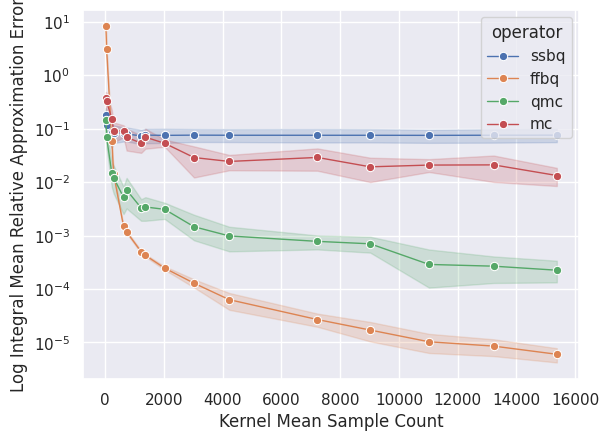

In [11]:
exps_sr_plot = exps_sr.copy()
exps_sr_plot["rel_err"] = exps_sr_plot["bqerr"] / exps_sr_plot["sol_mu"]

sns.set_theme()
fig = sns.lineplot(
    exps_sr_plot, x="Nconv", y="rel_err",
    linewidth=1, marker="o", hue="operator"
)
fig.set(yscale="log")
plt.xlabel("Kernel Mean Sample Count")
plt.ylabel("Log Integral Mean Relative Approximation Error")

plt.show()

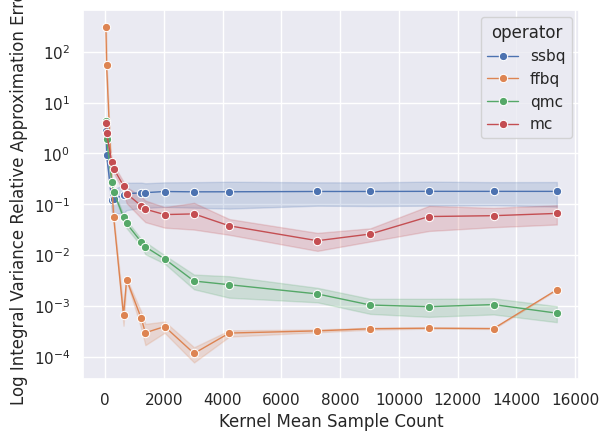

In [12]:
exps_sr_plot["rel_err_var"] = exps_sr_plot["bqvar_err"] / exps_sr_plot["sol_var"]

sns.set_theme()
fig = sns.lineplot(
    exps_sr_plot, x="Nconv", y="rel_err_var",
    linewidth=1, marker="o", hue="operator"
)
fig.set(yscale="log")
plt.xlabel("Kernel Mean Sample Count")
plt.ylabel("Log Integral Variance Relative Approximation Error")

plt.show()

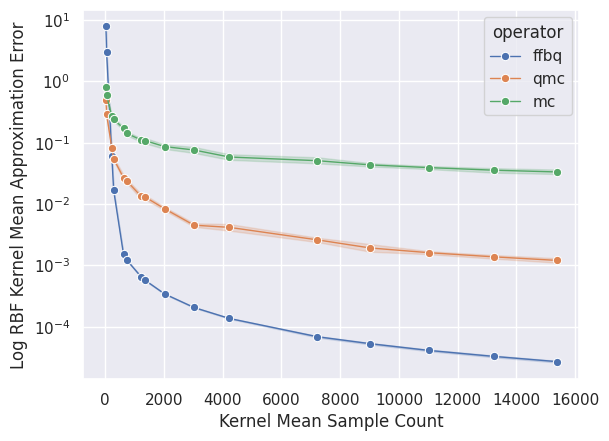

In [13]:
sns.set_theme()
fig = sns.lineplot(
    exps_sr_plot[exps_sr_plot["operator"] != "ssbq"], x="Nconv", y="bqz_err", hue="operator",
    linewidth=1, marker="o"
)
fig.set(yscale="log")
plt.xlabel("Kernel Mean Sample Count")
plt.ylabel("Log RBF Kernel Mean Approximation Error")

plt.show()

### Results over R

In [14]:
exp_name_R = "gmm_lr_R"
exps, exp_cols = get_experiments(exp_name_R, all_cols=True)
exps = exps[["R", "d", "sol_mu", "sol_var", "bqerr", "bqvar_err"]].astype(float)

In [15]:
r_sum = exps.groupby(["d", "R"])[["sol_mu", "sol_var", "bqerr", "bqvar_err"]].agg(("mean", "std")).reset_index()
r_sum.columns = ["_".join(col) if '' not in col else col[0] for col in r_sum.columns]
r_sum["rel_err"] = r_sum["bqerr_mean"] / r_sum["sol_mu_mean"]
r_sum["rel_err_var"] = r_sum["bqvar_err_mean"] / r_sum["sol_var_mean"]

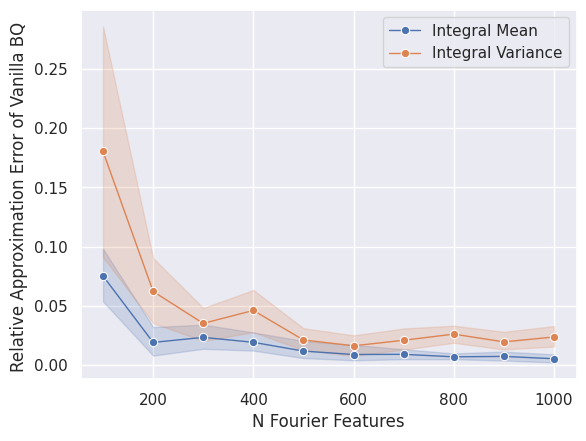

In [16]:
exp_plot = exps.copy()
exp_plot["rel_err"] = exp_plot["bqerr"] / exp_plot["sol_mu"]
exp_plot["rel_err_var"] = exp_plot["bqvar_err"] / exp_plot["sol_var"]

sns.set_theme()
fig = sns.lineplot(
    exp_plot[exp_plot["d"] == 2], x="R", y="rel_err",
    linewidth=1, marker="o", label="Integral Mean"
)
fig = sns.lineplot(
    exp_plot[exp_plot["d"] == 2], x="R", y="rel_err_var",
    linewidth=1, marker="o", label="Integral Variance"
)
plt.xlabel("N Fourier Features")
plt.ylabel("Relative Approximation Error of Vanilla BQ ")

plt.show()

In [17]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.view_init(elev=0., azim=0)
# ax.scatter(X_train[:, 0], X_train[:, 1], rff_qmc_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="mc", s=5)
# ax.scatter(X_train[:, 0], X_train[:, 1], rff_fft_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="fft", s=5)

# ax.legend()

In [ ]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.view_init(elev=0., azim=0)
# ax.plot_surface(Xg[:,:, 0], Xg[:,:,1], zG, linewidth=0, cmap=cm.viridis, antialiased=True)


In [ ]:
# Xg = grid(gmm.bounds, 5.5, flatten=False)
# zG, zG_pad = bq_fft.kmu_kvar(X, bounds=gmm.bounds, sr=5.5, bounded=False)

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# # ax.view_init(elev=0., azim=0)
# ax.plot_surface(Xg[:,:, 0], Xg[:,:,1], zG, linewidth=0, cmap=cm.viridis, antialiased=True)

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# # ax.view_init(elev=0., azim=0)
# ax.scatter(X[:, 0], X[:, 1], bq_z, linewidth=0, antialiased=True, label="bq", s=2)
# ax.scatter(X[:, 0], X[:, 1], qmc_z, linewidth=0, antialiased=True, label="qmc", s=2)
# ax.scatter(X[:, 0], X[:, 1], fft_z, linewidth=0, antialiased=True, label="fft", s=2)
# ax.legend()


## Final Plots

In [110]:
# plt.rcParams.update({

# })
sns.set_theme()
sns.set_context("paper", rc={
    # 'font.size': 10,
    "axes.labelsize": 13,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})
# plt.style.use('tex')

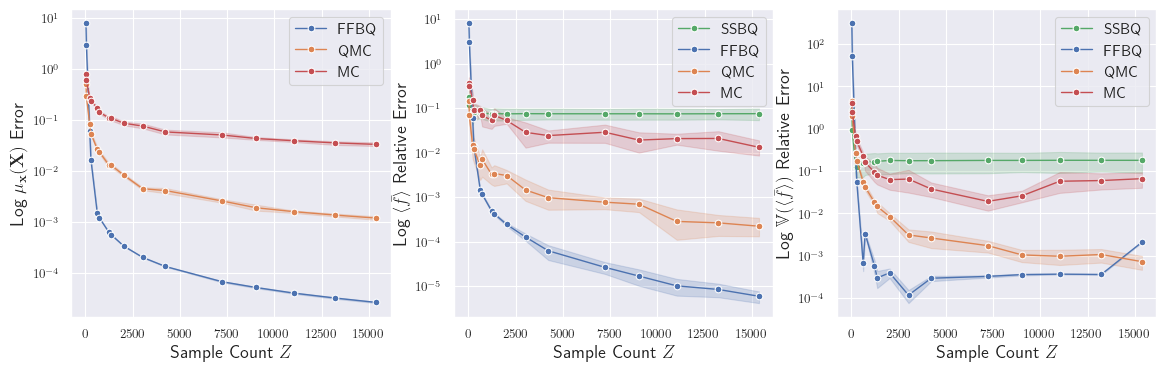

In [117]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

# KERNEL MEAN
exps_sr_plot = exps_sr.copy()
exps_sr_plot["rel_err"] = exps_sr_plot["bqerr"] / exps_sr_plot["sol_mu"]

sns.lineplot(
    exps_sr_plot[exps_sr_plot["operator"] != "ssbq"], x="Nconv", y="bqz_err", hue="operator",
    linewidth=1, marker="o", ax=ax[0], palette=["#4c72b0", "#dd8452", "#c44e52"]
)
ax[0].set(yscale="log", xlabel="Sample Count $Z$", ylabel="Log $\mu_{\mathbf{x}}(\mathbf{X})$ Error")
handles0, labels0 = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles0, labels=["FFBQ", "QMC", "MC"], fontsize=11)

# # MEAN
sns.lineplot(
    exps_sr_plot, x="Nconv", y="rel_err", palette=["#55a868", "#4c72b0", "#dd8452", "#c44e52"],
    linewidth=1, marker="o", hue="operator", ax=ax[1]
)
ax[1].set(yscale="log", xlabel="Sample Count $Z$", ylabel="Log $\langle \\bar{f} \\rangle$ Relative Error")
handles1, labels1 = ax[1].get_legend_handles_labels()
ax[1].legend(handles=handles1, labels=["SSBQ", "FFBQ", "QMC", "MC"], fontsize=11)

# # VARIANCE
exps_sr_plot["rel_err_var"] = exps_sr_plot["bqvar_err"] / exps_sr_plot["sol_var"]
sns.lineplot(
    exps_sr_plot, x="Nconv", y="rel_err_var",palette=["#55a868", "#4c72b0", "#dd8452", "#c44e52"],
    linewidth=1, marker="o", hue="operator", ax=ax[2]
)
ax[2].set(yscale="log", xlabel="Sample Count $Z$", ylabel="Log $\mathbb{V}(\langle \\bar{f} \\rangle)$ Relative Error")
handles2, labels2 = ax[2].get_legend_handles_labels()
ax[2].legend(handles=handles2, labels=["SSBQ", "FFBQ", "QMC", "MC"], fontsize=11)

# plt.show()


In [118]:
fig.savefig("gmm.pdf", format="pdf", bbox_inches="tight")

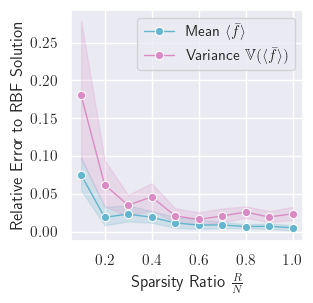

In [134]:
# # LOW RANK APPROXIMATION
fig, ax = plt.subplots(figsize=(3, 3))
exp_plot = exps.copy()
exp_plot["rel_err"] = exp_plot["bqerr"] / exp_plot["sol_mu"]
exp_plot["rel_err_var"] = exp_plot["bqvar_err"] / exp_plot["sol_var"]
exp_plot["sparsity"] = exp_plot["R"] / 1000

sns.set_theme()
sns.lineplot(
    exp_plot[exp_plot["d"] == 2], x="sparsity", y="rel_err",
    linewidth=1, marker="o", label="Mean $\langle \\bar{f} \\rangle$", c='#64b5cd', ax=ax
)
sns.lineplot(
    exp_plot[exp_plot["d"] == 2], x="sparsity", y="rel_err_var",
    linewidth=1, marker="o", label="Variance $\mathbb{V}(\langle \\bar{f} \\rangle)$", c='#da8bc3', ax=ax
)
ax.set(xlabel="Sparsity Ratio $\\frac{R}{N}$", ylabel="Relative Error to RBF Solution")
fig.savefig("ssbq.pdf", format="pdf", bbox_inches="tight")

# Ablation Studies

## Time Ablation - Kernel Mean

In [7]:
key = jax.random.PRNGKey(2023)
EXPERIMENT = "gmm_kmu_time_dev"

In [8]:
from ffbq.conv import gaussian_conv, mc_conv, qmc_conv, fft_conv
import time

def gaussian_bq_time_kmu(gp, m, X, y, key, diag=None):
    bq = BQ(gp, m)
    st = time.time()
    z, _ = bq.kmu_kvar(X)
    stp = time.time()
    kmu_time = stp - st

    return z, kmu_time

def mc_bq_time_kmu(gp, m, X, y, R, key, diag=None):
    bq = BQ(gp, m, operator="mc")
    st = time.time()
    z, _ = bq.kmu_kvar(X, R=min(R, 100000), key=key)
    stp = time.time()
    kmu_time = stp - st

    return z, kmu_time

def qmc_bq_time_kmu(gp, m, X, y, R, key, diag=None):
    bq = BQ(gp, m, operator="qmc")
    st = time.time()
    z, _ = bq.kmu_kvar(X, R=min(R, 100000), key=key)
    stp = time.time()
    kmu_time = stp - st

    return z, kmu_time

def fft_bq_time_kmu(gp, m, X, y, sr, bounds, diag=None):
    bq = BQ(gp, m, operator="fft")
    st = time.time()
    z, _ = bq.kmu_kvar(X, bounds=bounds, sr=sr, bounded=False)
    stp = time.time()
    kmu_time = stp - st

    return z, kmu_time


In [9]:
diag = 1e-4
lr = 0.01
epochs = 200

In [10]:
def single_run_gmm_time_kmu(d, R, N, sampling_rate, key, EXPERIMENT=None, log=True):
    print(f'd: {d}, R: {R}, N: {N}, sr: {sampling_rate}')

    diag_rbf = 1e-1
    diag_lr = 1e-1

    if EXPERIMENT is None:
        EXPERIMENT = "gmm_kmu_time_dev"

    gmm = GMMData(d)
    ls_init = jnp.ones(d)

    # make data
    train, val, test = generate_data(gmm, N * 3, N, N, noise=None, key=key)
    X_train, y_train = train
    X_val, y_val = val
    X_test, y_test = test
    Nconv = grid(gmm.bounds * 3, sampling_rate=sampling_rate / 3).shape[0]
    Nconv_cap = 100000
    Nrff_cap = 500000

    # --------------------------------------- TRAIN GPS -------------------------------------- #

    ###### BASIC BQ GP
    def build_train_bq_gp(X, y, opt, epochs, ls_init, diag):
        return GP(ARD(ls_init, RBF()), X, diag=diag)

    gp_bq_opt = optax.adam(lr)
    print("training basic gp...")
    gp_bq = build_train_bq_gp(X_train, y_train, gp_bq_opt, epochs, ls_init, diag)

    ###### RBF GP
    # def build_train_rbf_gp(support, X, y, opt, epochs, ls_init, diag):
    #     gp_pre = GP(FiniteARD(ls_init, RBF(), support), X, diag=diag)

    #     # train
    #     gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: t.kernel.scale, verbose=False, solver="full")
    #     return gp_pre, gp, loss

    # gp_rbf_opt = optax.adam(lr)
    # print("training rbf gp...")
    # _, gp_rbf, _ = build_train_rbf_gp(gmm.bounds, X_train, y_train, gp_rbf_opt, epochs, ls_init, diag)

    ###### LOW RANK RBF GP
    def build_train_lrgp_rbf(d, R, X, y, opt, epochs, ls_init, diag, key):
        return LowRankGP(ARD(ls_init, RFF(key, d, R)), X, diag=diag)

    gp_lr_rbf_opt = optax.adam(lr)
    print("training low rank rbf gp...")
    gp_lr_rbf = build_train_lrgp_rbf(d, R, X_train, y_train, gp_lr_rbf_opt, epochs, ls_init, diag_lr, key=key)

    # make test GPs for BQ
    gp_bq = eqx.tree_at(lambda t: t.X, gp_bq, replace_fn=lambda _: X_val)
    # gp_rbf = eqx.tree_at(lambda t: t.X, gp_rbf, replace_fn=lambda _: X_val)
    gp_lr_rbf = eqx.tree_at(lambda t: t.X, gp_lr_rbf, replace_fn=lambda _: X_val)

    # ---------------------------------------- RUN BQ ---------------------------------------- #
    m = tfd.MultivariateNormalDiag(jnp.zeros(d), jnp.ones(d) * 5)
    print("running BQ models...")

    ########## GAUSSIAN BQ
    rbf_z, rbf_ts = gaussian_bq_time_kmu(gp_bq, m, X_val, y_val, key, diag=diag_rbf)
    sol_mu = (None, 0)
    sol_var = (None, 0)
    sol_z = (rbf_z, 0)    
    sols = (sol_mu, sol_var, sol_z)

    ########## MC
    if Nconv > Nconv_cap:
        Nconv_mc = Nconv_cap
        print(f"Capping N mc from {Nconv} to {Nconv_cap}")
    else:
        Nconv_mc = Nconv

    rbf_mc_z, rbf_mc_ts = mc_bq_time_kmu(gp_bq, m, X_val, y_val, Nconv_mc, key, diag=diag_rbf)

    ########## QMC
    rbf_qmc_z, rbf_qmc_ts = qmc_bq_time_kmu(gp_bq, m, X_val, y_val, Nconv_mc, key, diag=diag_rbf)

    ########## FFBQ
    rbf_fft_z, rbf_fft_ts = fft_bq_time_kmu(
        gp_bq, m, X_val, y_val, sampling_rate / 3, bounds=gmm.bounds * 3, diag=diag_rbf
    )

    # ########## SSBQ (FFT)
    # if d < 5:
    #     lrfft_rbf_res, lrfft_rbf_var = lr_fft_bq(gp_lr_rbf, m, X_val, y_val, sampling_rate, gmm.bounds, diag=diag_lr_fft)

    # ----------------------------------- ERROR AND OUTPUT ----------------------------------- #
    
    mc_rel_errs = jnp.linalg.norm(rbf_mc_z - sol_z[0]) / N
    qmc_rel_errs = jnp.linalg.norm(rbf_qmc_z - sol_z[0]) / N
    ffbq_rel_errs = jnp.linalg.norm(rbf_fft_z - sol_z[0]) / N

    # if d < 5:
    #     ssbq_fft_rel_errs = jnp.abs(jnp.array([lrfft_rbf_res]) - sol[0]) / sol[0]
    # else:
    #     ssbq_fft_rel_errs = None

    print(f"""
        MC: {mc_rel_errs} \n
        QMC: {qmc_rel_errs} \n 
        FFBQ: {ffbq_rel_errs} \n 
    """)

    print(f"""
        BQ: {rbf_ts} \n
        MC: {rbf_mc_ts} \n
        QMC: {rbf_qmc_ts} \n
        FFBQ: {rbf_fft_ts} \n
    """)

    artifacts = {
        "gmm": gmm,
        "m": m,
        "val": (X_val, y_val),
        "test": (X_test, y_test),
        "gps": {
            "rbf": gp_bq,
            "lr_rbf": gp_lr_rbf,
        }
    }
    
    if not log:
        return artifacts

    # -------------------------------------- SAVE MODELS ------------------------------------- #

    ########## MC
    metric_gp_time(
        gp=gp_bq, bq_res=0, bq_var=0, bq_z=rbf_mc_z, t=rbf_mc_ts,
        y_val=y_val, X_test=X_test, y_test=y_test, sols=sols, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="mc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, diag=diag_rbf, t_baseline=rbf_ts
    )

    ########## QMC
    metric_gp_time(
        gp=gp_bq, bq_res=0, bq_var=0, bq_z=rbf_qmc_z, t=rbf_qmc_ts,
        y_val=y_val, X_test=X_test, y_test=y_test, sols=sols, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="qmc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, diag=diag_rbf, t_baseline=rbf_ts
    )

    ########## FFBQ
    metric_gp_time(
        gp=gp_bq, bq_res=0, bq_var=0, bq_z=rbf_fft_z, t=rbf_fft_ts,
        y_val=y_val, X_test=X_test, y_test=y_test, sols=sols, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="ffbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv, diag=diag_rbf, t_baseline=rbf_ts
    )

    del artifacts


In [11]:
def multi_seed_run_time_kmu(d, R, N, sampling_rate, global_key, n_runs=10, EXPERIMENT=None, log=True):
    run_keys = jax.random.split(global_key, n_runs + 1)

    artifacts = []
    # run once to compile code, discard result
    print("Running compilation run...")
    single_run_gmm_time_kmu(d, R, N, sampling_rate, run_keys[0], EXPERIMENT=EXPERIMENT, log=False)

    for rk in run_keys[1:]:
        print(f"starting experiment with seed {rk.tolist()[1]}")
        if log:
            single_run_gmm_time_kmu(d, R, N, sampling_rate, rk, EXPERIMENT=EXPERIMENT, log=log)
        else:
            run_artifacts = single_run_gmm_time_kmu(d, R, N, sampling_rate, rk, EXPERIMENT=EXPERIMENT, log=log)
            artifacts.append(run_artifacts)
    return artifacts

### Single Run - Kernel Mean Timing

In [12]:
# run_key = jax.random.PRNGKey(27)
# res = single_run_gmm_time_kmu(d=2, R=100, N=1000, sampling_rate=10, key=run_key, log=False)

### Multi-Run - Kernel Mean Time

In [13]:
def sample_rate_to_n(sr, ds):
    dim_lens = [
        jnp.linspace(-5, 5, int(sr[i] * 10)).shape[0]**ds[i]
        for i in range(len(sr))
    ]
    return dim_lens


# ds = [2, 3, 4, 5, 6, 7, 8]
#  9.5, 10, 12, 14, 16, 18, 20, 25, 30
srs = [0.5, 0.75, 1.5, 1.75, 2.5, 2.75, 3.5, 3.75, 4.5, 5.5, 6.5, 8.5, 9.5, 10.5, 11.5, 12.5]
ds = jnp.repeat(2, len(srs)).tolist()
print(ds, srs, sample_rate_to_n(srs, ds))

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] [0.5, 0.75, 1.5, 1.75, 2.5, 2.75, 3.5, 3.75, 4.5, 5.5, 6.5, 8.5, 9.5, 10.5, 11.5, 12.5] [25, 49, 225, 289, 625, 729, 1225, 1369, 2025, 3025, 4225, 7225, 9025, 11025, 13225, 15625]


In [14]:
exp_name_sr_time_kmu = "gmm_kmu_time_sr"

client = mlflow.MlflowClient()
client.delete_experiment(client.get_experiment_by_name(exp_name_sr_time_kmu).experiment_id)

In [ ]:
artifacts = []
for i, sr in enumerate(srs):
    print(f"# ------------------------------------------- {sr} ------------------------------------------ #")
    d_arts = multi_seed_run_time_kmu(
        d=ds[i], R=100, N=1000, sampling_rate=sr, global_key=key, 
        n_runs=10, EXPERIMENT=exp_name_sr_time_kmu, log=True)
    artifacts.append(d_arts)

## Time Ablation - Full

In [7]:
key = jax.random.PRNGKey(2023)
EXPERIMENT = "gmm_time_dev"

In [8]:
import time

def gaussian_bq_time(gp, m, X, y, key, diag=None):
    bq = BQ(gp, m)

    st = time.time()
    mu, sigma = bq(X, y, key=key, diag=diag)
    stp = time.time()
    bq_time = stp - st

    return mu, sigma, bq_time

def mc_bq_time(gp, m, X, y, R, key, diag=None):
    bq = BQ(gp, m, operator="mc")

    st = time.time()
    mu, sigma = bq(X, y, R=R, key=key,
                   diag=diag)
    stp = time.time()
    bq_time = stp - st

    return mu, sigma, bq_time

def qmc_bq_time(gp, m, X, y, R, key, diag=None):
    bq = BQ(gp, m, operator="qmc")

    st = time.time()
    mu, sigma = bq(X, y, R=R, key=key,
                   diag=diag)
    stp = time.time()
    bq_time = stp - st

    return mu, sigma, bq_time

def fft_bq_time(gp, m, X, y, sr, bounds, diag=None):
    bq = BQ(gp, m, operator="fft")

    st = time.time()
    mu, sigma = bq(X, y, bounds=bounds, sr=sr, diag=diag, bounded=False)
    stp = time.time()
    bq_time = stp - st
    return mu, sigma, bq_time

def lr_qmc_bq_time(gp, m, X, y, R, diag=None):
    bq = BQ(gp, m, operator="lr")

    st = time.time()
    mu, sigma = bq(X, y, R=R, diag=diag)
    stp = time.time()
    bq_time = stp - st
    return mu, sigma, bq_time

In [9]:
diag = 1e-4
lr = 0.01
epochs = 200

In [10]:
def single_run_gmm_time(d, R, N, sampling_rate, key, EXPERIMENT=None, log=True):
    print(f'd: {d}, R: {R}, N: {N}, sr: {sampling_rate}')

    diag_rbf = 1e-1
    diag_lr = 1e-1

    if EXPERIMENT is None:
        EXPERIMENT = "gmm_time_dev"

    gmm = GMMData(d)
    ls_init = jnp.ones(d)

    # make data
    train, val, test = generate_data(gmm, N * 3, N, N, noise=None, key=key)
    X_train, y_train = train
    X_val, y_val = val
    X_test, y_test = test
    Nconv = grid(gmm.bounds * 3, sampling_rate=sampling_rate / 3).shape[0]
    Nconv_cap = 100000
    Nrff_cap = 500000

    # --------------------------------------- TRAIN GPS -------------------------------------- #

    ###### BASIC BQ GP
    def build_train_bq_gp(X, y, opt, epochs, ls_init, diag):
        return GP(ARD(ls_init, RBF()), X, diag=diag)

    gp_bq_opt = optax.adam(lr)
    print("training basic gp...")
    gp_bq = build_train_bq_gp(X_train, y_train, gp_bq_opt, epochs, ls_init, diag)

    ###### RBF GP
    # def build_train_rbf_gp(support, X, y, opt, epochs, ls_init, diag):
    #     gp_pre = GP(FiniteARD(ls_init, RBF(), support), X, diag=diag)

    #     # train
    #     gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: t.kernel.scale, verbose=False, solver="full")
    #     return gp_pre, gp, loss

    # gp_rbf_opt = optax.adam(lr)
    # print("training rbf gp...")
    # _, gp_rbf, _ = build_train_rbf_gp(gmm.bounds, X_train, y_train, gp_rbf_opt, epochs, ls_init, diag)

    ###### LOW RANK RBF GP
    def build_train_lrgp_rbf(d, R, X, y, opt, epochs, ls_init, diag, key):
        return LowRankGP(ARD(ls_init, RFF(key, d, R)), X, diag=diag)

    gp_lr_rbf_opt = optax.adam(lr)
    print("training low rank rbf gp...")
    gp_lr_rbf = build_train_lrgp_rbf(d, R, X_train, y_train, gp_lr_rbf_opt, epochs, ls_init, diag_lr, key=key)

    # make test GPs for BQ
    gp_bq = eqx.tree_at(lambda t: t.X, gp_bq, replace_fn=lambda _: X_val)
    # gp_rbf = eqx.tree_at(lambda t: t.X, gp_rbf, replace_fn=lambda _: X_val)
    gp_lr_rbf = eqx.tree_at(lambda t: t.X, gp_lr_rbf, replace_fn=lambda _: X_val)

    # ---------------------------------------- RUN BQ ---------------------------------------- #
    m = tfd.MultivariateNormalDiag(jnp.zeros(d), jnp.ones(d) * 5)
    print("running BQ models...")

    ########## GAUSSIAN BQ
    rbf_mu, rbf_var, rbf_ts = gaussian_bq_time(gp_bq, m, X_val, y_val, key, diag=diag_rbf)
    sol_mu = (rbf_mu, 0)
    sol_var = (rbf_var, 0)
    sol_z = (None, None)
    sols = (sol_mu, sol_var, sol_z)

    ########## MC
    if Nconv > Nconv_cap:
        Nconv_mc = Nconv_cap
        print(f"Capping N mc from {Nconv} to {Nconv_cap}")
    else:
        Nconv_mc = Nconv

    rbf_mc_res, rbf_mc_var, rbf_mc_ts = mc_bq_time(gp_bq, m, X_val, y_val, Nconv_mc, key, diag=diag_rbf)

    ########## QMC
    rbf_qmc_res, rbf_qmc_var, rbf_qmc_ts = qmc_bq_time(gp_bq, m, X_val, y_val, Nconv_mc, key, diag=diag_rbf)

    ########## FFBQ
    rbf_fft_res, rbf_fft_var, rbf_fft_ts = fft_bq_time(
        gp_bq, m, X_val, y_val, sampling_rate / 3, bounds=gmm.bounds * 3, diag=diag_rbf
    )

    ########## SSBQ (QMC)
    if Nconv > Nrff_cap:
        Nrff = Nrff_cap
        print(f"Capping N RFF from {Nconv} to {Nrff_cap}")
    else:
        Nrff = Nconv
    lr_rbf_res, lr_rbf_var, lr_rbf_ts = lr_qmc_bq_time(gp_lr_rbf, m, X_val, y_val, Nrff, diag=diag_lr)

    # ----------------------------------- ERROR AND OUTPUT ----------------------------------- #
    mc_rel_errs = jnp.abs(rbf_mc_res - sols[0][0]) / sols[0][0]
    qmc_rel_errs = jnp.abs(rbf_qmc_res - sols[0][0]) / sols[0][0]
    ffbq_rel_errs = jnp.abs(rbf_fft_res - sols[0][0]) / sols[0][0]
    ssbq_rel_errs = jnp.abs(lr_rbf_res - sols[0][0]) / sols[0][0]
    
    print(f"""
        MC: {mc_rel_errs} \n
        QMC: {qmc_rel_errs} \n 
        FFBQ: {ffbq_rel_errs} \n 
        SSBQ (QMC): {ssbq_rel_errs} \n
    """)

    print(f"""
        BQ: {rbf_ts} \n
        MC: {rbf_mc_ts} \n
        QMC: {rbf_qmc_ts} \n
        FFBQ: {rbf_fft_ts} \n
        SSBQ (QMC): {lr_rbf_ts} \n
    """)

    artifacts = {
        "gmm": gmm,
        "m": m,
        "val": (X_val, y_val),
        "test": (X_test, y_test),
        "gps": {
            "rbf": gp_bq,
            "lr_rbf": gp_lr_rbf,
        }
    }
    
    if not log:
        return artifacts

    # -------------------------------------- SAVE MODELS ------------------------------------- #


    ########## MC
    metric_gp_time(
        gp=gp_bq, bq_res=rbf_mc_res, bq_var=rbf_mc_var, bq_z=None, t=rbf_mc_ts,
        y_val=y_val, X_test=X_test, y_test=y_test, sols=sols, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="mc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, diag=diag_rbf, t_baseline=rbf_ts
    )

    ########## QMC
    metric_gp_time(
        gp=gp_bq, bq_res=rbf_qmc_res, bq_var=rbf_qmc_var, bq_z=None, t=rbf_qmc_ts,
        y_val=y_val, X_test=X_test, y_test=y_test, sols=sols, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="qmc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, diag=diag_rbf, t_baseline=rbf_ts
    )

    ########## FFBQ
    metric_gp_time(
        gp=gp_bq, bq_res=rbf_fft_res, bq_var=rbf_fft_var, bq_z=None, t=rbf_fft_ts,
        y_val=y_val, X_test=X_test, y_test=y_test, sols=sols, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="ffbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv, diag=diag_rbf, t_baseline=rbf_ts
    )

    ########## SSBQ
    metric_gp_time(
        gp=gp_lr_rbf, bq_res=lr_rbf_res, bq_var=lr_rbf_var, bq_z=None, t=lr_rbf_ts,
        y_val=y_val, X_test=X_test, y_test=y_test, sols=sols, 
        experiment=EXPERIMENT, gptype="lr", ktype="rbf", bqtype="ssbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nrff, R=R, diag=diag_lr, t_baseline=rbf_ts
    )

    del artifacts


In [11]:
def multi_seed_run_time(d, R, N, sampling_rate, global_key, n_runs=10, EXPERIMENT=None, log=True):
    run_keys = jax.random.split(global_key, n_runs + 1)

    artifacts = []
    # run once to compile code, discard result
    print("Running compilation run...")
    single_run_gmm_time(d, R, N, sampling_rate, run_keys[0], EXPERIMENT=EXPERIMENT, log=False)

    for rk in run_keys[1:]:
        print(f"starting experiment with seed {rk.tolist()[1]}")
        if log:
            single_run_gmm_time(d, R, N, sampling_rate, rk, EXPERIMENT=EXPERIMENT, log=log)
        else:
            run_artifacts = single_run_gmm_time(d, R, N, sampling_rate, rk, EXPERIMENT=EXPERIMENT, log=log)
            artifacts.append(run_artifacts)
    return artifacts

### Single Run - Full Time

In [12]:
# run_key = jax.random.PRNGKey(27)
# res = single_run_gmm_time(d=2, R=100, N=1000, sampling_rate=10, key=run_key, log=True)

### Multi-Run - Full Time

In [13]:
def sample_rate_to_n(sr, ds):
    dim_lens = [
        jnp.linspace(-5, 5, int(sr[i] * 10)).shape[0]**ds[i]
        for i in range(len(sr))
    ]
    return dim_lens

# ds = [2, 3, 4, 5, 6, 7, 8]
#  9.5, 10, 12, 14, 16, 18, 20, 25, 30
srs = [0.5, 0.75, 1.5, 1.75, 2.5, 2.75, 3.5, 3.75, 4.5, 5.5, 6.5, 8.5, 9.5, 10.5, 11.5, 12.5]
ds = jnp.repeat(2, len(srs)).tolist()
print(ds, srs, sample_rate_to_n(srs, ds))

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] [0.5, 0.75, 1.5, 1.75, 2.5, 2.75, 3.5, 3.75, 4.5, 5.5, 6.5, 8.5, 9.5, 10.5, 11.5, 12.5] [25, 49, 225, 289, 625, 729, 1225, 1369, 2025, 3025, 4225, 7225, 9025, 11025, 13225, 15625]


In [14]:
exp_name_sr_time = "gmm_time"

client = mlflow.MlflowClient()
client.delete_experiment(client.get_experiment_by_name(exp_name_sr_time).experiment_id)

In [ ]:
artifacts = []
for i, sr in enumerate(srs):
    print(f"# ------------------------------------------- {sr} ------------------------------------------ #")
    d_arts = multi_seed_run_time(
        d=ds[i], R=100, N=1000, sampling_rate=sr, global_key=key, 
        n_runs=10, EXPERIMENT=exp_name_sr_time, log=True)
    artifacts.append(d_arts)

### Single Run

In [18]:
# run_key = jax.random.PRNGKey(28)
# res = single_run_gmm_time(d=2, R=100, N=1000, sampling_rate=10, key=run_key, log=False)
# runs = multi_seed_run(d=3, R=100, N=1000, sampling_rate=12, global_key=key, n_runs=5, log=False)

# gp_rbf = res["gps"]["rbf"]
# lr_rff = res["gps"]["lr_rff"]
# lr_rbf = res["gps"]["lr_rbf"]
# X, y = res["val"]
# m = res["m"]
# genz = res["genz"]
# Nconv = grid(genz.bounds, 16).shape[0]
# grid_dims = grid(genz.bounds, 16, flatten=False).shape[:-1]

# rbf_res, rbf_z = gaussian_bq(gp_rbf, m, X, y, genz.bounds, key, diag=1e-1)
# fft_rbf_res, fft_rbf_z = fft_bq(gp_rbf, m, X, y, 16, genz.bounds, diag=1e-1)
# qmc_rbf_res, qmc_rbf_z = qmc_bq(gp_rbf, m, X, y, Nconv, genz.bounds, diag=1e-1, key=key)
# lrqmc_res, _ = lr_qmc_bq(lr_rbf, m, X, y, 100000, genz.bounds, diag=1e-1)
# lrfft_res, _ = lr_fft_bq(lr_rbf, m, X, y, sampling_rate=16, bounds=genz.bounds, diag=1e-1)
# rbf_res, qmc_rbf_res, fft_rbf_res, lrqmc_res, lrfft_res

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.view_init(elev=0., azim=0)
# ax.scatter(X[:, 0], X[:, 1], rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="bq", s=5)
# ax.scatter(X[:, 0], X[:, 1], qmc_rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="qmc", s=5)
# ax.scatter(X[:, 0], X[:, 1], fft_rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="fft", s=5)

# ax.legend()

d: 2, R: 100, N: 1000, sr: 10
training basic gp...
training low rank rbf gp...
running BQ models...

        MC: 0.02868136391043663 

        QMC: 0.0010884619550779462 
 
        FFBQ: 2.2525919121108018e-05 
 
        SSBQ (QMC): 0.09012357890605927 

    

        BQ: 0.05802178382873535 

        MC: 0.27207088470458984 

        QMC: 0.275378942489624 

        FFBQ: 0.12714695930480957 

        SSBQ (QMC): 0.05692005157470703 

    


## Noise Ablation

In [7]:
key = jax.random.PRNGKey(2023)
EXPERIMENT = "gmm_noise_dev"

In [8]:
def gaussian_bq_noise(gp, m, X, y, key, diag):
    bq = BQ(gp, m)
    mu, sigma = bq(X, y, key=key, diag=diag)

    return mu, sigma

def mc_bq_noise(gp, m, X, y, R, key, diag):
    bq = BQ(gp, m, operator="mc")
    mu, sigma = bq(X, y, R=R, key=key,
                   diag=diag)

    return mu, sigma

def qmc_bq_noise(gp, m, X, y, R, key, diag):
    bq = BQ(gp, m, operator="qmc")
    mu, sigma = bq(X, y, R=R, key=key,
                   diag=diag)

    return mu, sigma

def fft_bq_noise(gp, m, X, y, sr, bounds, diag):
    bq = BQ(gp, m, operator="fft")
    mu, sigma = bq(X, y, bounds=bounds, sr=sr, diag=diag, bounded=False)
    
    return mu, sigma

def lr_qmc_bq_noise(gp, m, X, y, R, diag):
    bq = BQ(gp, m, operator="lr")
    mu, sigma = bq(X, y, R=R, diag=diag)

    return mu, sigma

In [10]:
lr = 0.01
epochs = 200

In [11]:
def single_run_gmm_noise(d, R, N, sampling_rate, diag, key, EXPERIMENT=None, log=True):
    print(f'd: {d}, R: {R}, N: {N}, sr: {sampling_rate}, diag: {diag}')

    if EXPERIMENT is None:
        EXPERIMENT = "gmm_noise_dev"

    gmm = GMMData(d)
    ls_init = jnp.ones(d)

    # make data
    train, val, test = generate_data(gmm, N * 3, N, N, noise=None, key=key)
    X_train, y_train = train
    X_val, y_val = val
    X_test, y_test = test
    Nconv = grid(gmm.bounds * 3, sampling_rate=sampling_rate / 3).shape[0]
    Nconv_cap = 100000
    Nrff_cap = 500000

    # --------------------------------------- TRAIN GPS -------------------------------------- #

    ###### BASIC BQ GP
    def build_train_bq_gp(X, y, opt, epochs, ls_init, diag):
        return GP(ARD(ls_init, RBF()), X, diag=diag)

    gp_bq_opt = optax.adam(lr)
    print("training basic gp...")
    gp_bq = build_train_bq_gp(X_train, y_train, gp_bq_opt, epochs, ls_init, diag)

    ###### LOW RANK RBF GP
    def build_train_lrgp_rbf(d, R, X, y, opt, epochs, ls_init, diag, key):
        return LowRankGP(ARD(ls_init, RFF(key, d, R)), X, diag=diag)

    gp_lr_rbf_opt = optax.adam(lr)
    print("training low rank rbf gp...")
    gp_lr_rbf = build_train_lrgp_rbf(d, R, X_train, y_train, gp_lr_rbf_opt, epochs, ls_init, diag, key=key)

    # make test GPs for BQ
    gp_bq = eqx.tree_at(lambda t: t.X, gp_bq, replace_fn=lambda _: X_val)
    # gp_rbf = eqx.tree_at(lambda t: t.X, gp_rbf, replace_fn=lambda _: X_val)
    gp_lr_rbf = eqx.tree_at(lambda t: t.X, gp_lr_rbf, replace_fn=lambda _: X_val)

    # ---------------------------------------- RUN BQ ---------------------------------------- #
    m = tfd.MultivariateNormalDiag(jnp.zeros(d), jnp.ones(d) * 5)
    print("running BQ models...")

    ########## GAUSSIAN BQ
    rbf_mu, rbf_var = gaussian_bq_noise(gp_bq, m, X_val, y_val, key, diag=diag)
    sol = (rbf_mu, 0)

    ########## MC
    if Nconv > Nconv_cap:
        Nconv_mc = Nconv_cap
        print(f"Capping N mc from {Nconv} to {Nconv_cap}")
    else:
        Nconv_mc = Nconv

    rbf_mc_res, rbf_mc_var = mc_bq_noise(gp_bq, m, X_val, y_val, Nconv_mc, key, diag=diag)

    ########## QMC
    rbf_qmc_res, rbf_qmc_var = qmc_bq_noise(gp_bq, m, X_val, y_val, Nconv_mc, key, diag=diag)

    ########## FFBQ
    rbf_fft_res, rbf_fft_var = fft_bq_noise(
        gp_bq, m, X_val, y_val, sampling_rate / 3, bounds=gmm.bounds * 3, diag=diag
    )

    ########## SSBQ (QMC)
    if Nconv > Nrff_cap:
        Nrff = Nrff_cap
        print(f"Capping N RFF from {Nconv} to {Nrff_cap}")
    else:
        Nrff = Nconv
    lr_rbf_res, lr_rbf_var = lr_qmc_bq_noise(gp_lr_rbf, m, X_val, y_val, Nrff, diag=diag)

    # ----------------------------------- ERROR AND OUTPUT ----------------------------------- #
    mc_rel_errs = jnp.abs(rbf_mc_res - sol[0]) / sol[0]
    qmc_rel_errs = jnp.abs(rbf_qmc_res - sol[0]) / sol[0]
    ffbq_rel_errs = jnp.abs(rbf_fft_res - sol[0]) / sol[0]
    ssbq_rel_errs = jnp.abs(lr_rbf_res - sol[0]) / sol[0]
    
    print(f"""
        MC: {mc_rel_errs} \n
        QMC: {qmc_rel_errs} \n 
        FFBQ: {ffbq_rel_errs} \n 
        SSBQ (QMC): {ssbq_rel_errs} \n
    """)

    artifacts = {
        "gmm": gmm,
        "m": m,
        "val": (X_val, y_val),
        "test": (X_test, y_test),
        "gps": {
            "rbf": gp_bq,
            "lr_rbf": gp_lr_rbf,
        }
    }
    
    if not log:
        return artifacts

    # -------------------------------------- SAVE MODELS ------------------------------------- #
    ########## MC
    metric_gp_bq(
        gp=gp_bq, bq_res=rbf_mc_res, bq_var=rbf_mc_var,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="mc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, diag=diag
    )

    ########## QMC
    metric_gp_bq(
        gp=gp_bq, bq_res=rbf_qmc_res, bq_var=rbf_qmc_var,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="qmc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, diag=diag
    )

    ########## FFBQ
    metric_gp_bq(
        gp=gp_bq, bq_res=rbf_fft_res, bq_var=rbf_fft_var, 
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="ffbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv, diag=diag
    )

    ########## SSBQ
    metric_gp_bq(
        gp=gp_lr_rbf, bq_res=lr_rbf_res, bq_var=lr_rbf_var,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="lr", ktype="rbf", bqtype="ssbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nrff, R=R, diag=diag
    )

    del artifacts


In [12]:
def multi_seed_run_noise(d, R, N, sampling_rate, diag, global_key, n_runs=10, EXPERIMENT=None, log=True):
    run_keys = jax.random.split(global_key, n_runs)

    artifacts = []
    for rk in run_keys:
        print(f"starting experiment with seed {rk.tolist()[1]}")
        if log:
            single_run_gmm_noise(d, R, N, sampling_rate, diag, rk, EXPERIMENT=EXPERIMENT, log=log)
        else:
            run_artifacts = single_run_gmm_noise(d, R, N, sampling_rate, diag, rk, EXPERIMENT=EXPERIMENT, log=log)
            artifacts.append(run_artifacts)
    return artifacts

### Single Run - Noise

In [13]:
# run_key = jax.random.PRNGKey(27)
# res = single_run_gmm_noise(d=2, R=100, N=1000, diag=1e-1, sampling_rate=10, key=run_key, log=False)

### Multi-Run - Noise

In [14]:
mults = jnp.logspace(-5, 0, 5)
bases = jnp.linspace(0.1, 1.1, 6)[:-1]

diags = jnp.concatenate([b * mults for b in bases]).sort().tolist()

In [15]:
exp_name_sr_noise = "gmm_noise"

client = mlflow.MlflowClient()
client.delete_experiment(client.get_experiment_by_name(exp_name_sr_noise).experiment_id)

AttributeError: 'NoneType' object has no attribute 'experiment_id'

In [16]:
artifacts = []
for i, diag in enumerate(diags):
    print(f"# ------------------------------------------ {diag} ----------------------------------------- #")
    d_arts = multi_seed_run_noise(
        d=2, R=100, N=1000, sampling_rate=10, diag=diag, global_key=key, 
        n_runs=10, EXPERIMENT=exp_name_sr_noise, log=True)
    artifacts.append(d_arts)

# ------------------------------------------ 9.999999974752427e-07 ----------------------------------------- #
starting experiment with seed 1318783524
d: 2, R: 100, N: 1000, sr: 10, diag: 9.999999974752427e-07
training basic gp...
training low rank rbf gp...
running BQ models...


2023/12/04 16:22:33 INFO mlflow.tracking.fluent: Experiment with name 'gmm_noise' does not exist. Creating a new experiment.



        MC: 0.015543646179139614 

        QMC: 3.4059496556437807e-06 
 
        FFBQ: 0.000380040641175583 
 
        SSBQ (QMC): 0.060560163110494614 

    
starting experiment with seed 516604179
d: 2, R: 100, N: 1000, sr: 10, diag: 9.999999974752427e-07
training basic gp...
training low rank rbf gp...
running BQ models...

        MC: 0.02766473777592182 

        QMC: 0.00016513826267328113 
 
        FFBQ: 0.0004233400395605713 
 
        SSBQ (QMC): 0.04807772859930992 

    
starting experiment with seed 1229449355
d: 2, R: 100, N: 1000, sr: 10, diag: 9.999999974752427e-07
training basic gp...
training low rank rbf gp...
running BQ models...

        MC: 0.02790822833776474 

        QMC: 0.0008346005924977362 
 
        FFBQ: 0.0001282355806324631 
 
        SSBQ (QMC): 0.03763330355286598 

    
starting experiment with seed 764367963
d: 2, R: 100, N: 1000, sr: 10, diag: 9.999999974752427e-07
training basic gp...
training low rank rbf gp...
running BQ models...

        MC: